### 메인 퀘스트 : 한국어 데이터로 만든 챗봇모델을 GPT1모델로 구현하기

### [QUEST 평가기준 1 Transformer와 비교해 변경이 필요한 부분을 서술하였다.]
- 제출 노트북 파일 첫부분에 텍스트 블럭으로 서술합니다. 아키텍쳐 상 변경사항을 블럭단위로 서술합니다.  
- 코드블럭에 변경사항을 주석으로 표시합니다.  

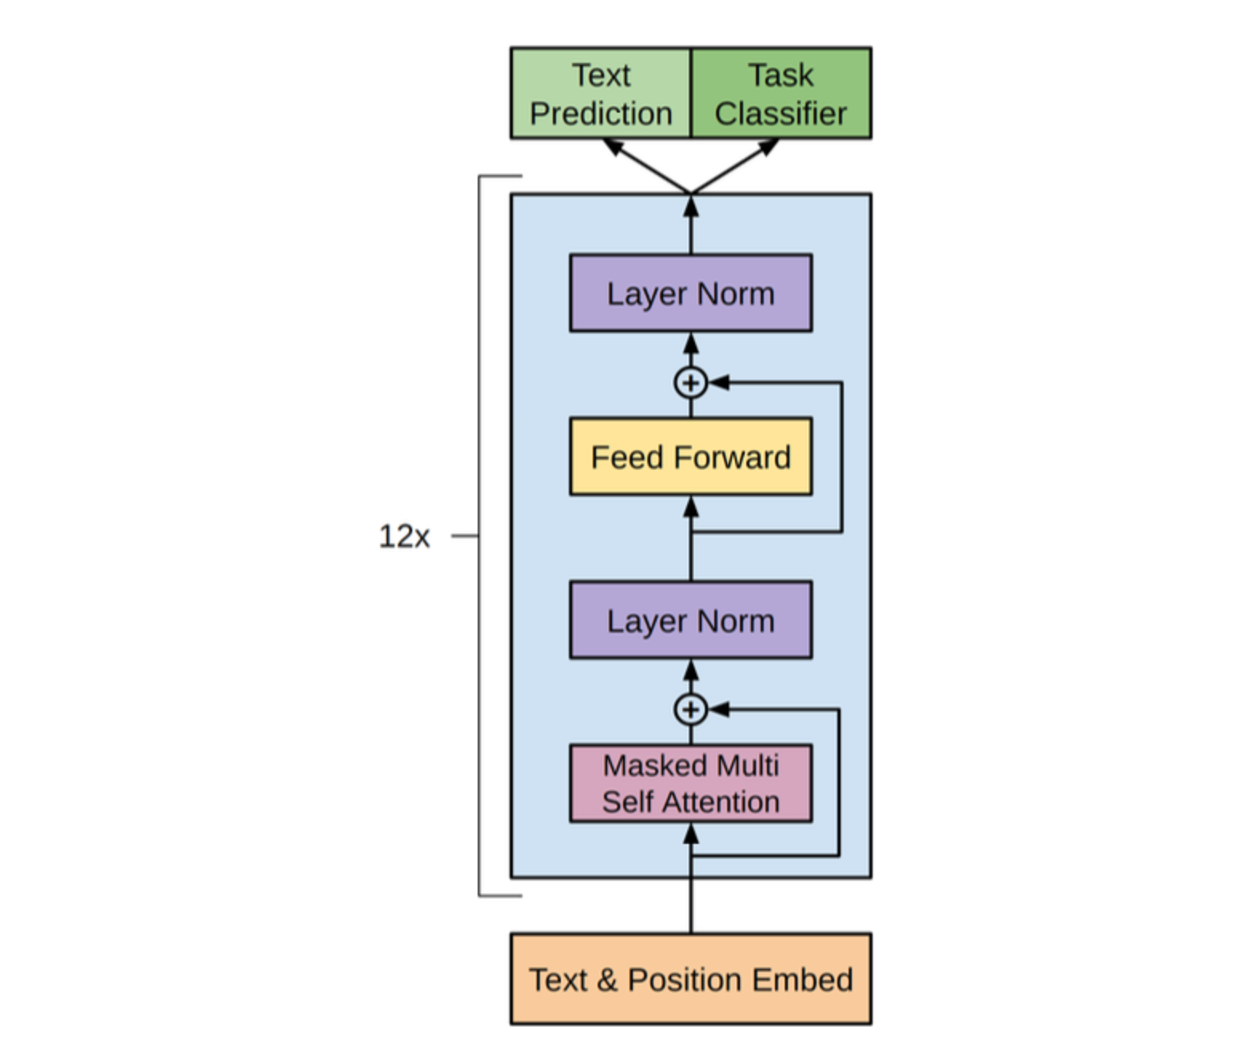

### 기존 챗봇 모델의 디코더 구조 
- 변경된 부분의 블록은 # 주석처리 및, [ ] 으로 설명하였습니다.
- 논문의 gpt1모델은 인코더는 사용되지 않고, 디코더 단만을 활용합니다.
- 기존 챗봇모델 프로젝트의 트랜스포머 디코더 구조는, 3개의 어텐션 구조를 사용합니다. 하지만 위 GPT1모델의 경우 Masked Multi self attetion만을 사용하여 컨텍스트를 학습하고, 그에 따른 예측 단어의 확률을 출력합니다.
- 2개의 피드포워드 네트워크와, 드랍아웃층 및 LayerNormalization 층, 잔차연결 및 룩어헤드 마스크를 사용하는 것은 기존 챗봇모델의 디코더 단과 유사한 점이라 할 수 있습니다.

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs) # Residual Connection(잔차 연결): 원래 입력(inputs)과 어텐션 결과를 더함.

# [인코더 디코더 어텐션이 사용되지 않습니다]
#   # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#           'key': enc_outputs, # Key, Value: 인코더 출력(enc_outputs).
#           'value': enc_outputs,
#           'mask': padding_mask # Padding Mask를 적용하여 인코더 출력에서 패딩된 토큰을 무시.
#       })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)


  # 세 번째 서브 레이어 : 2개의 완전연결층 = 피드포워드 네트워크
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

### 변경한 부분 GPT1 모델의 트랜스포머

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        
        # 2개의 Dense 레이어로 구성. FFN을 정의 : 비선형 활성화를 통해 모델의 표현력을 증가시킵니다.
        self.ffn = tf.keras.Sequential([ 
            tf.keras.layers.Dense(dff, activation='relu'), #W1x+b
            tf.keras.layers.Dense(d_model) #W2x + b2
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        # Mask 생성: 시퀀스 길이에 따라 하삼각 행렬을 생성하여 미래 정보를 차단
        seq_len = tf.shape(inputs)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # 하삼각 행렬

        # Masked Multi-Head Attention
        attn_output = self.attention(inputs, inputs)
        # Query와 Key 간의 점곱(내적)을 통해 각 토큰 간의 유사도를 계산 & 가중치 적용, V에 적용하여 출력 계산.
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        """
        GPT-1에서는 “마스크드(Self-Attention)“을 적용합니다. 이는 각 단어가 자신보다 미래의 단어를 보지 않도록 설정하여 순차적 학습을 유도합니다.
        마스킹의 주요 역할:
        - 정답 단어를 예측할 때, 이전 단어만 보고 예측하게 함.
        - 언어 모델의 Causal Dependency를 유지.
        """
        # FFN은 Self-Attention에서 학습된 정보를 추가적으로 변환하고 비선형성을 적용하여 더 복잡한 패턴을 학습합니다.
        ffn_output = self.ffn(out1) # 2개의 완전연결층(Dense) 구성
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output) # 잔차연결을 정규화
        return out2
    
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout_rate': self.dropout_rate
        })
        return config

In [83]:
# 필요 패키지
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


In [84]:
# from google.colab import drive
# drive.mount('/content/drive')

### Pr07에서 진행한 부분은 Step1.으로 표시하겠습니다.
- 다른 언어데이터를 바탕으로 pre training을 시도해보고자 했으나, 입력에 따른 출력을 생성하는 퀘스트5번을 고려 안전한 방식으로 시도해보고자 합니다.
- 질문 답변을 각각 나누어서 학습을 한다면, unsupervised learning이 아니기 때문에, 질문 답변의 시퀀스를 하나의 텍스트 시퀀스로 합쳐 라벨이 정해지지 않은 언어 생성 학습을 진행합니다.

### Step 1-1. 데이터 수집하기

In [85]:
import pandas as pd
# 데이터를 읽어봅시다.
data = pd.read_table('~/aiffel/Untitled Folder/ChatbotData.csv')
# test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/sentiment_classification/data/ratings_test.txt')
data_path = '~/aiffel/Untitled Folder/ChatbotData.csv'
print(data.head())
print(data.info)

                       Q,A,label
0            12시 땡!,하루가 또 가네요.,0
1        1지망 학교 떨어졌어,위로해 드립니다.,0
2     3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3  3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4           PPL 심하네,눈살이 찌푸려지죠.,0
<bound method DataFrame.info of                                                Q,A,label
0                                    12시 땡!,하루가 또 가네요.,0
1                                1지망 학교 떨어졌어,위로해 드립니다.,0
2                             3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3                          3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4                                   PPL 심하네,눈살이 찌푸려지죠.,0
...                                                  ...
11818                훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819                     훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820                               흑기사 해주는 짝남.,설렜겠어요.,2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아...
11822                    힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2

[11823 rows x 1 columns]>


### Step 1-2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.
<참조PR> :


In [86]:
import re

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823

# 한글 데이터에 맞는 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence의 양쪽 공백을 제거
    sentence = sentence.strip()

    # 특수 문자를 분리하고, 필요 없는 문자는 공백으로 대체
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 앞뒤로 공백 추가
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)  # 한글, 영문, 숫자, 구두점 제외한 문자 제거 #! 핵심!
    sentence = re.sub(r'[" "]+', " ", sentence)  # 다중 공백을 단일 공백으로 치환

    """
	•	r" \1 ":
	•	\1은 ()로 캡처된 패턴을 참조.
	•	예: 구두점 .이 캡처되었다면, \1은 .으로 변환.
    
	•	[^...]: 대괄호 안에 포함되지 않은 문자들을 매칭.
	•	가-힣: 한글 범위 (자음, 모음 포함).
	•	a-zA-Z: 영어 소문자 및 대문자.
	•	0-9: 숫자.
	•	?.!,: 구두점.
	•	+: 앞의 패턴이 1번 이상 반복되는 경우 매칭.
    
	•	정규식 패턴:
	•	[" "]: 공백 문자를 매칭.
	•	+: 앞의 패턴이 1번 이상 반복되는 경우 매칭.
    
    
    """
    
    # 최종 양쪽 공백 제거
    sentence = sentence.strip()

    return sentence

# 데이터 로드 및 전처리 함수
def load_conversations_from_csv(file_path):
    # CSV 파일 읽기
    data = pd.read_csv(file_path, header=None)

    # 질문과 답변 분리 및 전처리 적용
    questions = data[0].apply(preprocess_sentence).tolist()
    answers = data[1].apply(preprocess_sentence).tolist()

    # 샘플 개수 제한
    questions = questions[:MAX_SAMPLES]
    answers = answers[:MAX_SAMPLES]

    return questions, answers

In [87]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
questions, answers = load_conversations_from_csv(data_path)
# 결과 확인
print("샘플 질문:", questions[:5])
print("샘플 답변:", answers[:5])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

샘플 질문: ['Q', '12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다']
샘플 답변: ['A', '하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .']
전체 샘플 수 : 11823
전체 샘플 수 : 11823


- 데이터 셋을 살펴보면, 한글 단어만 있는 것이 아닌 영단어도 섞여 있음을 고려해야 했습니다.

In [88]:
max_length = max(len(q) for q in questions)
print("샘플 중 가장 긴 질문의 길이:", max_length)

# 질문 길이의 평균 계산
average_length = sum(len(q) for q in questions) / len(questions)
print("질문의 평균 길이:", average_length)

샘플 중 가장 긴 질문의 길이: 57
질문의 평균 길이: 13.212974710310412


- Max_Length를 고려하여 , 각 샘플 길이의 평균과 max를 구했습니다.

### Step2 라벨 분리 및 질문 답변 결합 => 하나의 텍스트 시퀀스로 바꾸기
### [QUEST 평가기준 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.]
- Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.  
- 이번 과제는 pretrain을 위한 데이터셋과 학습만 고려합니다.


### Step2-1. vocab_size 구하기

In [89]:
from collections import Counter

# 모든 질문과 답변을 결합한 텍스트 데이터
all_text = " ".join(questions + answers)

# 단어 빈도 계산
word_counts = Counter(all_text.split())

# 단어 빈도를 내림차순으로 정렬
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# 누적 빈도 계산
total_words = sum(word_counts.values())
cumulative_coverage = 0
vocab_size = 0

for i, (_, count) in enumerate(sorted_counts):
    cumulative_coverage += count / total_words
    if cumulative_coverage >= 0.95:  # 상위 95% 커버
        vocab_size = i + 1
        break

print(f"95% 단어 커버를 위한 추천 vocab_size: {vocab_size}")

95% 단어 커버를 위한 추천 vocab_size: 15537


- 위를 바탕으로 vocab_size는 15537로 정합니다. 

### Step2-2. unsupervised learning임을 고려하여, 라벨 합치기

In [90]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

def preprocess_data_combined(data_path, vocab_size=8000, max_length=40, context_window=1):
    """
    GPT-1 형식으로 질문과 답변을 결합하여 데이터를 전처리합니다.
    Args:
        data_path: 데이터 파일 경로 (CSV 파일).
        vocab_size: 어휘 크기.
        max_length: 시퀀스 최대 길이.
        context_window: 컨텍스트 윈도우 크기.
    Returns:
        input_data: 모델 입력 데이터 (컨텍스트).
        target_data: 모델 타겟 데이터 (다음 단어).
        tokenizer: 텍스트 토크나이저.
    """
    # 데이터 로드
    data = pd.read_csv(data_path, header=None)
    questions = data[0].tolist()
    answers = data[1].tolist()

    # 질문과 답변을 하나의 연속된 텍스트 데이터로 결합
    combined_texts = [q + " <sep> " + a for q, a in zip(questions, answers)]
    # '<sep>'은 질문과 답변의 경계를 명확히 하기 위한 토큰

    # 텍스트 토큰화
    tokenizer = Tokenizer(num_words=vocab_size, filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(combined_texts)
    all_sequences = tokenizer.texts_to_sequences(combined_texts)

    # 시퀀스 패딩
    all_sequences = pad_sequences(all_sequences, maxlen=max_length, padding='post')

    # 컨텍스트-타겟 데이터 생성
    input_data, target_data = [], []
    for seq in all_sequences:
        for i in range(context_window, len(seq)):
            input_data.append(seq[i-context_window:i])  # 컨텍스트
            target_data.append(seq[i])  # 타겟 단어

    return np.array(input_data), np.array(target_data), tokenizer

# 데이터 전처리 실행
data_path = '~/aiffel/Untitled Folder/ChatbotData.csv'  # 데이터 파일 경로
input_data, target_data, tokenizer = preprocess_data_combined(data_path)

# 결과 출력
print("Input shape:", input_data.shape)
print("Target shape:", target_data.shape)
print("Tokenizer word index:", list(tokenizer.word_index.items())[:100])  # 일부 단어 출력

Input shape: (461136, 1)
Target shape: (461136,)
Tokenizer word index: [('<unk>', 1), ('<sep>', 2), ('거예요.', 3), ('수', 4), ('너무', 5), ('더', 6), ('좋아하는', 7), ('거', 8), ('잘', 9), ('것', 10), ('많이', 11), ('안', 12), ('좋은', 13), ('게', 14), ('사람', 15), ('같아요.', 16), ('좀', 17), ('있어요.', 18), ('있을', 19), ('사람이', 20), ('싶어', 21), ('나', 22), ('마세요.', 23), ('건', 24), ('같아', 25), ('내가', 26), ('해보세요.', 27), ('이제', 28), ('마음이', 29), ('내', 30), ('썸', 31), ('다', 32), ('왜', 33), ('그', 34), ('어떻게', 35), ('다른', 36), ('있는', 37), ('다시', 38), ('수도', 39), ('시간이', 40), ('또', 41), ('오늘', 42), ('정말', 43), ('좋을', 44), ('이별', 45), ('하고', 46), ('하는', 47), ('것도', 48), ('같이', 49), ('할', 50), ('자꾸', 51), ('될', 52), ('없어요.', 53), ('없어', 54), ('걸', 55), ('한', 56), ('돼요.', 57), ('바랄게요.', 58), ('싶다', 59), ('제가', 60), ('저도', 61), ('먼저', 62), ('진짜', 63), ('헤어진지', 64), ('그런', 65), ('나를', 66), ('마음을', 67), ('여자친구가', 68), ('계속', 69), ('없는', 70), ('혼자', 71), ('남자친구가', 72), ('못', 73), ('때', 74), ('보세요.', 75), ('않아요.', 76), ('하세요

- 기존 챗봇 모델은 질문과 답변으로 나누어 학습을 진행한 supervised 모델이었습니다. 이에 라벨을 질문 텍스트쪽에 집어 넣어, 라벨이 없는 상황에서 텍스트만을 학습하는 unsupervised 학습을 진행토록 하였습니다.
- 354,720개 샘플, 컨텍스트 윈도우: 10 -> 10개의 토큰을 보고 다음 단어를 예측하도록 학습함을 의미합니다.
- target : 각 입력에 대해 하나의 타겟 단어가 존재, 이는 컨텍스트를 기반으로 다음 단어를 예측하는데 사용됩니다.
- Tokenizer word index : 사용한 단어와 인덱스 (sep: 구분자 토큰) (거예요=3 : 가장 자주 등장하는 단어로 인덱스 3번 배치)  
    -> 빈도기반으로 구성

### Step2-2. TransformerBlock 생성 - 위에서 설명한 것과 동일 합니다.
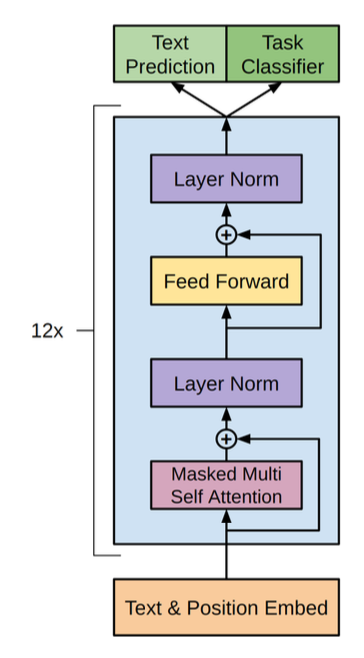

In [91]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        
        # 2개의 Dense 레이어로 구성. FFN을 정의 : 비선형 활성화를 통해 모델의 표현력을 증가시킵니다.
        self.ffn = tf.keras.Sequential([ 
            tf.keras.layers.Dense(dff, activation='relu'), #W1x+b
            tf.keras.layers.Dense(d_model) #W2x + b2
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        # Mask 생성: 시퀀스 길이에 따라 하삼각 행렬을 생성하여 미래 정보를 차단
        seq_len = tf.shape(inputs)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # 하삼각 행렬

        # Masked Multi-Head Attention
        attn_output = self.attention(inputs, inputs)
        # Query와 Key 간의 점곱(내적)을 통해 각 토큰 간의 유사도를 계산 & 가중치 적용, V에 적용하여 출력 계산.
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        """
        GPT-1에서는 “마스크드(Self-Attention)“을 적용합니다. 이는 각 단어가 자신보다 미래의 단어를 보지 않도록 설정하여 순차적 학습을 유도합니다.
        마스킹의 주요 역할:
        - 정답 단어를 예측할 때, 이전 단어만 보고 예측하게 함.
        - 언어 모델의 Causal Dependency를 유지.
        """
        # FFN은 Self-Attention에서 학습된 정보를 추가적으로 변환하고 비선형성을 적용하여 더 복잡한 패턴을 학습합니다.
        ffn_output = self.ffn(out1) # 2개의 완전연결층(Dense) 구성
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output) # 잔차연결을 정규화
        return out2
    
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout_rate': self.dropout_rate
        })
        return config

- 논문에 기반하여 트랜스포머 블록을 구성하였습니다.
- Masked Multi self attention과, Layernorm, FFN, 잔차연결을 수행 하였습니다.

### Step2-3. GPT1Model for Chatbot 생성
### ### [QUEST 평가기준 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.]
- 모델의 input이 정상적으로 구성되었는지 확인합니다.
- 데이터에 위치 정보를 추가하는 과정을 구현합니다.

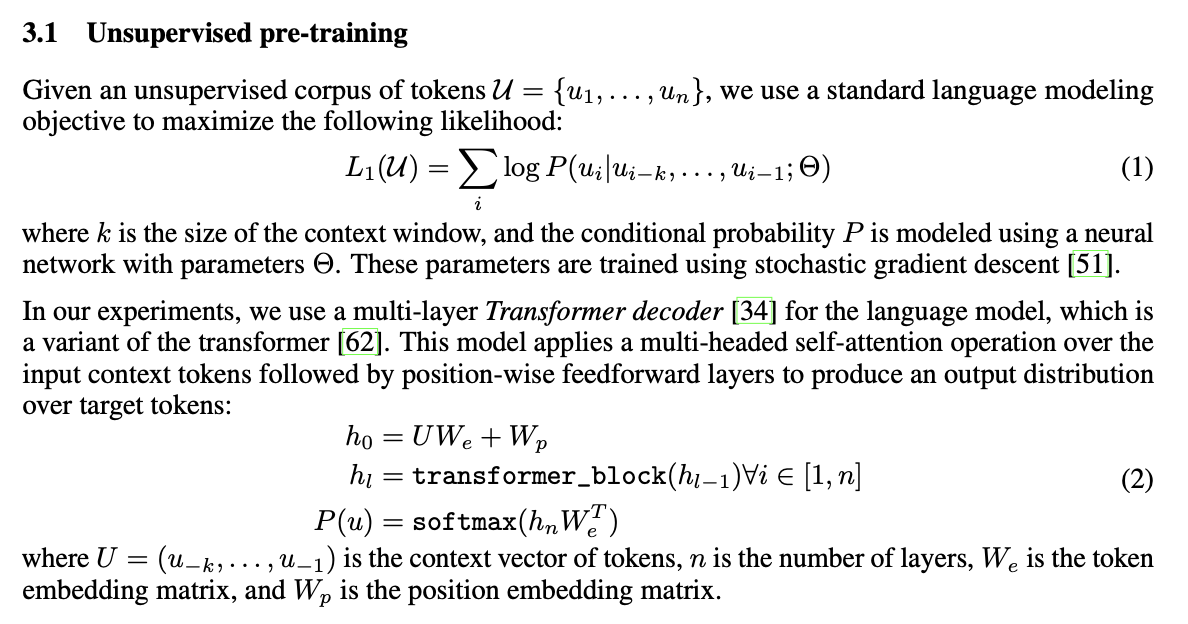

In [92]:
class GPT1Model_forChatbot(tf.keras.Model):
    def __init__(self, vocab_size, max_seq_len, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        """
        GPT-1 언어 모델 구성.
        Args:
            vocab_size: 어휘 크기.
            max_seq_len: 시퀀스 최대 길이.
            num_layers: Transformer 레이어 수.
            d_model: 임베딩 차원.
            num_heads: 멀티-헤드 어텐션 헤드 수.
            dff: 피드포워드 네트워크 은닉층 크기.
            dropout_rate: 드롭아웃 비율.
        """
        super(GPT1Model_forChatbot, self).__init__()
        self.token_embedding = tf.keras.layers.Embedding(vocab_size, d_model)  # 토큰 임베딩
        self.pos_embedding = tf.keras.layers.Embedding(max_seq_len, d_model)  # 위치 임베딩
        
        # 12개의 트랜스포머 블록 반복. h0~h11까지 반환
        self.transformer_blocks = [
            TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(vocab_size)  # 출력 레이어

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1] # 토큰 시퀀스(배치크기,시퀀스길이)
        token_emb = self.token_embedding(inputs)
        # 각 토큰은 정수로 인코딩된 input -> 이를 각각 임베딩벡터의 고차원 벡터로 반환
        # token_emb(배치크기,시퀀스길이,임베딩차원)으로 출력
        # 각 토큰을 고차원 벡터로 매핑하여, 단어 간의 의미적 유사도를 학습
        pos_indices = tf.range(seq_len) # 각 토큰의 위치정보 생성
        pos_emb = self.pos_embedding(pos_indices)

        x = token_emb + pos_emb  # h_0
        """
        입력 토큰이 들어오면, 각 토큰을 고유한 벡터로 변환하는 **토큰 임베딩(Token Embedding)**과 
        해당 토큰의 위치 정보를 나타내는 **위치 임베딩(Position Embedding)**을 더하여
        초기 입력  h_0 를 생성합니다.
        # 두 텐서를 더하기 위해, pos_emb는 자동으로 브로드캐스팅됩니다.
        """
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)  # h_l
        
        
        # Transformer 블록의 출력  h_n 을 소프트맥스 레이어에 전달하여 단어 확률 분포를 계산.
        # 출력은 각 단어가 다음에 나올 확률을 나타냄.
        logits = self.output_layer(x)  # softmax(h_n W_e^T), Dense 레이어로 구현되어  W_e^T 를 곱함.
        return logits
    
    def get_config(self):
        config = super(GPT1Model_forChatbot, self).get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'max_seq_len': self.max_seq_len,
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'dropout_rate': self.dropout_rate
        })
        return config

- 논문에 기반하여, 모델의 입력 블럭을 수정하였습니다.
- 각 토큰을 token embedding과 position embedding 매트릭스를 사용하여 초기 입력 h0를 생성하였습니다.
- 이후 트랜스포머 블록을 통과한 hl은 단어간 문맥적 의미를 학습합니다. 최종 트랜스포머 블록의 출력x는 모델의 최종적인 문맥적 표현입니다. (문맥 정보를 담은 벡터)

### [QUEST 평가기준 4. GPT 모델을 정상적으로 구성하였다.]
### (model.summary, model.fit 결과 캡쳐 첨부) - 하단 참조
- 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.






In [93]:
# GPT-1 모델 생성
vocab_size = 15537
max_seq_len = 40
num_layers = 12
d_model = 128 # 작은 데이터 셋 고려
num_heads = 12
# Transformer 논문(Attention Is All You Need) : dff = 4 * d_model
dff = 512

gpt1_model = GPT1Model_forChatbot(vocab_size, max_seq_len, num_layers, d_model, num_heads, dff)

In [111]:
gpt1_model.summary()

Model: "gp_t1model_for_chatbot_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  1988736   
_________________________________________________________________
embedding_9 (Embedding)      multiple                  5120      
_________________________________________________________________
transformer_block_48 (Transf multiple                  923392    
_________________________________________________________________
transformer_block_49 (Transf multiple                  923392    
_________________________________________________________________
transformer_block_50 (Transf multiple                  923392    
_________________________________________________________________
transformer_block_51 (Transf multiple                  923392    
_________________________________________________________________
transformer_block_52 (Transf multiple     

### Step2-4. 모델 훈련



In [95]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

batch_size = 64
epochs = 10
learning_rate = 5e-5

# 데이터 전처리
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 손실 함수 정의
loss_object = SparseCategoricalCrossentropy(from_logits=True)

# 손실 함수 디버깅을 위한 확인
print(f"Input data shape: {input_data.shape}")  # (num_samples, seq_len)
print(f"Target data shape: {target_data.shape}")  # (num_samples, )

# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)



Input data shape: (461136, 1)
Target data shape: (461136,)


In [109]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# 하이퍼파라미터 설정
batch_size = 64
epochs = 10
learning_rate = 5e-5

# TF 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 손실 함수 정의
loss_object = SparseCategoricalCrossentropy(from_logits=True)

# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
gpt1_model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

from tensorflow.keras.callbacks import ModelCheckpoint

# 체크포인트 설정 (가중치만 저장)
checkpoint_filepath = '/aiffel/aiffel/workplace/gpt1_model_checkpoint.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # 체크포인트 경로
    save_best_only=True,           # 최적의 모델만 저장
    monitor='loss',                # 손실 기준
    mode='min',                    # 최소 손실 기준
    verbose=1,
    save_weights_only=True         # 가중치만 저장
)

# 모델 학습
history = gpt1_model.fit(train_dataset, epochs=epochs, callbacks=[checkpoint_callback])

# 저장된 가중치 로드
gpt1_model.load_weights(checkpoint_filepath)
print("Model training complete and weights loaded successfully.")

Epoch 1/10
7206/7206 [==============================] - 264s 35ms/step - loss: 1.0951 - accuracy: 0.8561

Epoch 00001: loss improved from inf to 1.09510, saving model to /aiffel/aiffel/workplace/gpt1_model_checkpoint.keras
Epoch 2/10
7206/7206 [==============================] - 254s 35ms/step - loss: 1.0411 - accuracy: 0.8570

Epoch 00002: loss improved from 1.09510 to 1.04110, saving model to /aiffel/aiffel/workplace/gpt1_model_checkpoint.keras
Epoch 3/10
7206/7206 [==============================] - 258s 36ms/step - loss: 1.0147 - accuracy: 0.8577

Epoch 00003: loss improved from 1.04110 to 1.01471, saving model to /aiffel/aiffel/workplace/gpt1_model_checkpoint.keras
Epoch 4/10
7206/7206 [==============================] - 260s 36ms/step - loss: 0.9960 - accuracy: 0.8583

Epoch 00004: loss improved from 1.01471 to 0.99601, saving model to /aiffel/aiffel/workplace/gpt1_model_checkpoint.keras
Epoch 5/10
7206/7206 [==============================] - 255s 35ms/step - loss: 0.9808 - accuracy

In [108]:
# 모델 체크포인트 디버깅
import os
import tensorflow as tf

# 저장할 경로 설정
save_dir = '/aiffel/aiffel/workplace'

# 경로가 없으면 생성
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created: {save_dir}")
else:
    print(f"Directory already exists: {save_dir}")

# 모델 저장 파일 경로 설정
model_save_path = os.path.join(save_dir, 'gpt1_model_checkpoint.keras')

# TensorFlow 모델 저장
gpt1_model.save_weights(model_save_path, save_format='keras')  # 또는 save_format='tf'
print(f"Model saved at: {model_save_path}")

Directory already exists: /aiffel/aiffel/workplace
Model saved at: /aiffel/aiffel/workplace/gpt1_model_checkpoint.keras


In [ ]:
# # 모델 저장
# model.save('gpt1_model_with_config')

# # 모델 로드
# loaded_model = tf.keras.models.load_model('gpt1_model_with_config')

### Step2-4. 모델 평가

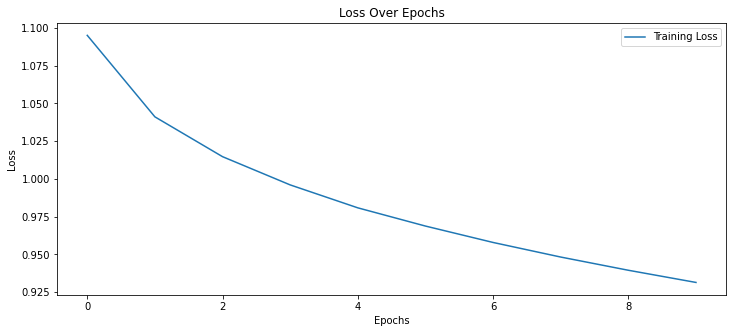

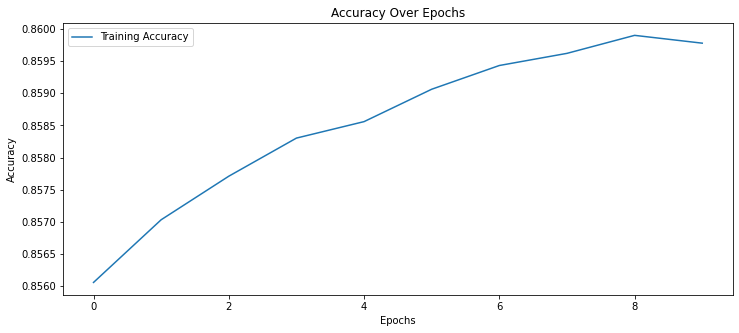

In [112]:
# 손실 어큐러시 평가
# 손실 그래프 그리기
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프 그리기
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

- train과 valdation set을 미리 나눠볼걸 이라는 아쉬움이 남습니다.

In [ ]:
# 4. 평가 (Perplexity)
def calculate_perplexity(model, input_data, target_data):
    predictions = model(input_data, training=False)
    loss = loss_object(target_data, predictions)
    perplexity = tf.exp(loss)
    return perplexity.numpy()

perplexity = calculate_perplexity(gpt1_model, input_data, target_data)
print(f"Model Perplexity: {perplexity}")

### 입력에 따른 출력 
### [QUEST 평가기준 5. 입력에 따른 출력이 생성되었다.]
- 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.


In [114]:
def generate_text(model, tokenizer, input_text, max_length, temperature=1.0):
    """
    GPT-1 모델을 사용하여 입력 텍스트로부터 텍스트를 생성합니다.
    Args:
        model: GPT-1 모델.
        tokenizer: 텍스트 토크나이저.
        input_text: 입력 텍스트.
        max_length: 생성할 텍스트의 최대 길이.
        temperature: 샘플링 온도 조절 파라미터 (1.0 기본값).
    Returns:
        generated_text: 생성된 텍스트.
    """
    # 입력 텍스트를 시퀀스로 변환
    input_sequence = tokenizer.texts_to_sequences([input_text])[0]
    generated_sequence = input_sequence.copy()

    for _ in range(max_length):
        # 입력 데이터를 텐서로 변환
        input_tensor = tf.convert_to_tensor([generated_sequence[-max_seq_len:]])

        # 모델 예측
        predictions = model(input_tensor, training=False)  # logits 출력
        logits = predictions[:, -1, :] / temperature  # 마지막 토큰에 대한 확률 조정
        predicted_id = tf.random.categorical(logits, num_samples=1)[0, 0].numpy()  # 샘플링

        # 예측된 토큰을 시퀀스에 추가
        generated_sequence.append(predicted_id)

        # 최대 길이 도달 시 중단
        if len(generated_sequence) >= max_length:
            break

    # 시퀀스를 텍스트로 변환
    generated_text = tokenizer.sequences_to_texts([generated_sequence])[0]
    return generated_text

Generated Text: 오늘 날씨가 확실히 좋아하는 너무 오랫동안 <unk> <unk> 한 <unk> 좀. 엄청 잠이 영화 그럴까? 전 결과가 <unk> 쉽게 같지


In [161]:
# Example usage
input_text = "나는 궁금해"  # 시작 문장
max_length = 5  # 최대 생성 길이
generated_text = generate_text(gpt1_model, tokenizer, input_text, max_length=max_length)
print("Generated Text:", generated_text)

Generated Text: 나는 궁금해 좋아하는 봐요. 좀


In [217]:
# Example usage2
input_text = "가족 여행"  # 시작 문장
max_length = 5  # 최대 생성 길이
generated_text = generate_text(gpt1_model, tokenizer, input_text, max_length=max_length)
print("Generated Text:", generated_text)

Generated Text: 가족 여행 있다고 했는데 연애하면


- 챗봇모델의 역할을 전혀 하지 못함을 확인할 수 있습니다.
- 이는 질문 답변의 텍스트를 한군데로 모아 학습한 영향이 있다고 생각되며,
- 챗봇 모델이라는 역할을 수행하게끔 구조를 변경하고, supervied fine tuning을 한다면 좀더 좋은 결과가 나올수도 있다고 생각합니다. 

### 루브릭
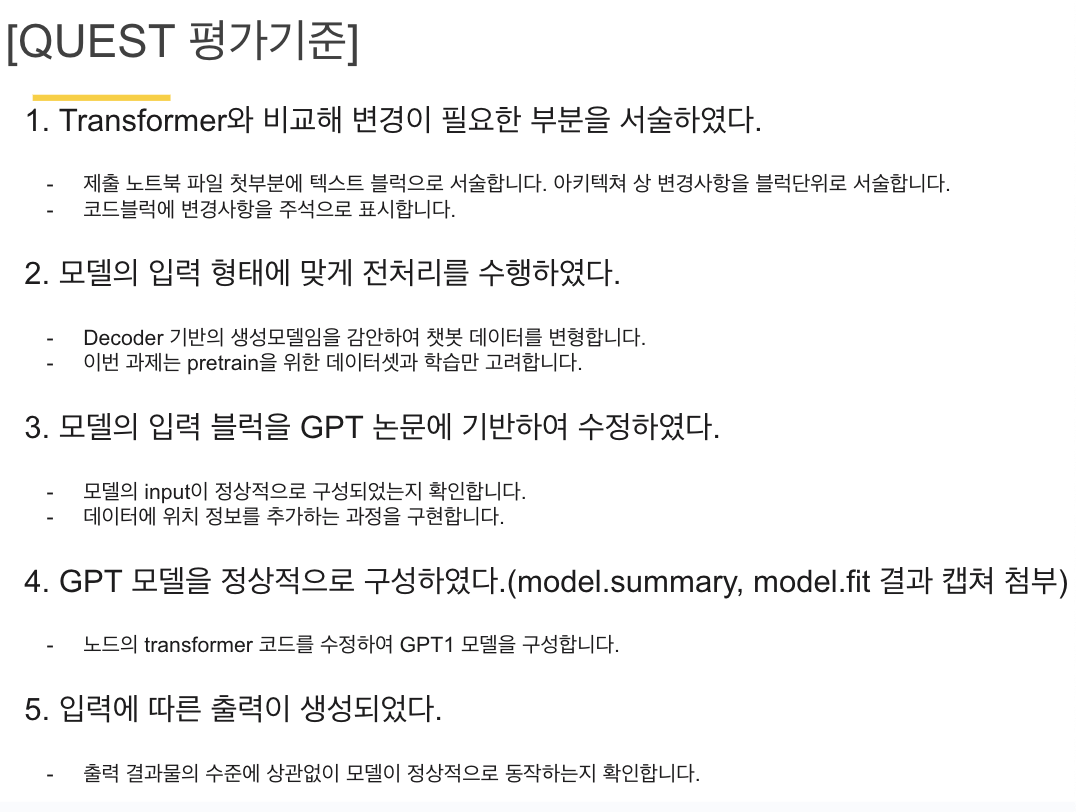

### 최종회고

- 아직도 코드를 짜면서 무에서 유를 창조하는 코드는 많이 버겁다고 느꼈습니다..
- 이전 만들어진 틀을 참조하거나, 작성에 있어 모르는 부분은 gpt의 도움을 받았습니다.
- 논문에 대해 supervied fine tuning 부분에, 헷갈린 부분이 있어 확실하게 이해하지 못했는데 프로젝트를 진행하면서 다시금 살펴볼 수 있어 좋았습니다.
- 추후 컨텍스트 윈도우 크기를 변경해서도 시도해보고자 합니다.
- 궁금한점은 퍼실님께 추가적으로 여쭙도록 하겠습니다.